In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense ,Conv2D ,MaxPool2D ,Flatten ,InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import os
import shutil
import random

In [2]:
train_dir = "data/train"
val_dir = "data/val"
split_ratio = 0.2  # 20% untuk validation

os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    val_count = int(len(images) * split_ratio)

    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in images[:val_count]:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_class_dir, img)
        shutil.move(src, dst)

In [3]:
for split in ['train', 'test', 'val']:
    dir = f"data/{split}"
    print(f"\n{split}")
    for cls in os.listdir(dir):
        cls_dir = os.path.join(dir, cls)
        if os.path.isdir(cls_dir):
            print(f"{cls}: {len(os.listdir(cls_dir))}")


train
Apple_Apple_scab_504: 1854
Apple_Black_rot_496: 1854
Apple_healthy_1316: 1854

test
Apple_Apple_scab_504: 936
Apple_Black_rot_496: 936
Apple_healthy_1316: 936

val
Apple_Apple_scab_504: 2670
Apple_Black_rot_496: 2670
Apple_healthy_1316: 2670


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
train = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
val = test_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
test = test_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5562 images belonging to 3 classes.
Found 2808 images belonging to 3 classes.
Found 2808 images belonging to 3 classes.


In [6]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(150,150,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(train.num_classes, activation='softmax')
])

model.compile(
    optimizer = Adam(learning_rate=0.0005),
    loss = 'categorical_crossentropy',
    metrics = (['accuracy'])
)

c:\Users\PREDATOR\Documents\Project\Plant-Disease-Classification\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    start_from_epoch=4
)

checkpoint = ModelCheckpoint(
    'model/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [8]:
history = model.fit(
    train,
    epochs = 50,
    validation_data = val,
    callbacks = [early_stopping, checkpoint, reduce_lr]
)

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 258ms/step - accuracy: 0.7368 - loss: 0.6415 - val_accuracy: 0.3333 - val_loss: 2.1306 - learning_rate: 5.0000e-04
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 47s 269ms/step - accuracy: 0.8369 - loss: 0.4175 - val_accuracy: 0.3465 - val_loss: 2.5682 - learning_rate: 5.0000e-04
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 47s 268ms/step - accuracy: 0.8637 - loss: 0.3739 - val_accuracy: 0.6756 - val_loss: 0.7364 - learning_rate: 5.0000e-04
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - accuracy: 0.8821 - loss: 0.3201 - val_accuracy: 0.8593 - val_loss: 0.3618 - learning_rate: 5.0000e-04
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 264ms/step - accuracy: 0.8909 - loss: 0.2834 - val_accuracy: 0.9245 - val_loss: 0.2103 - learning_rate: 5.0000e-04
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - accuracy: 0.9112 - loss: 0.2360 - val_accuracy: 0.8910 - val_loss: 0.2617 - learning_rate: 5.0000e-04
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 26

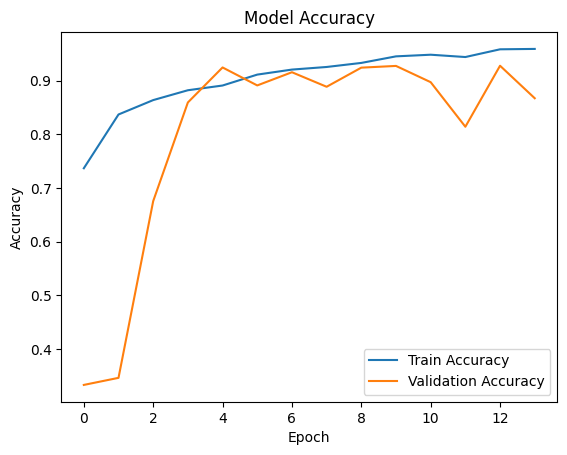

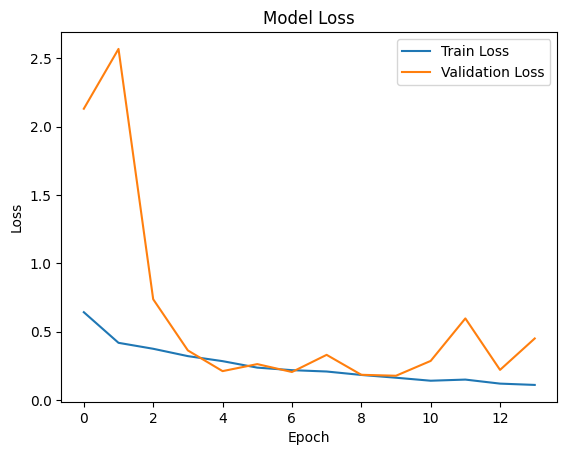

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
test_loss, test_acc = model.evaluate(test)

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9274 - loss: 0.1765
